# X5

In [167]:
import random

import numpy as np
import pandas as pd

import torch

torch.cuda.empty_cache()

def seed_all(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

In [168]:
SEED = 42
# seed_all(SEED)

In [169]:
from pathlib import Path

DATA_PATH = Path('../../../data/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

DATA_PATH_DOWNLOAD = DATA_PATH / Path('download/')
DATA_PATH_DOWNLOAD.mkdir(parents=True, exist_ok=True)

DATA_PATH_DATASET = DATA_PATH / Path('datasets/')
DATA_PATH_DATASET.mkdir(parents=True, exist_ok=True)

DATA_SYNTHETICS = DATA_PATH / Path('synthetics/')
DATA_PATH_DATASET.mkdir(parents=True, exist_ok=True)

DATA_CACHE = DATA_PATH / Path('cache_dir/')
DATA_CACHE.mkdir(parents=True, exist_ok=True)

DATA_PATH_SAVE_MODELS = DATA_PATH / Path('models/')
DATA_PATH_SAVE_MODELS.mkdir(parents=True, exist_ok=True)

DATA_IMGS = DATA_PATH /  Path('imgs/')
DATA_IMGS.mkdir(parents=True, exist_ok=True)

import pandas as pd

pd.set_option('display.max_colwidth', 500) 

In [170]:
import sys
import os

project_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(project_path)

In [171]:
BASE_MODEL_NAME = 'cointegrated/rubert-tiny2'
# BASE_MODEL_NAME = 'MoritzLaurer/mDeBERTa-v3-base-mnli-xnli'
# BASE_MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MODEL_NAME_SAVE = "ner_x5"
MODEL_CHECKPOINT_PATH = "ner_x5_checkpoint"

In [172]:
from datetime import datetime

current_date = datetime.now().strftime("%d-%m-%Y")
DATA_LOG = DATA_PATH / Path(f'../logs/{MODEL_NAME_SAVE}_{current_date}')
DATA_LOG.mkdir(parents=True, exist_ok=True)

In [173]:
MAX_LENGTH = 16
BATCH_SIZE = 128

# Данные

In [174]:
df_x5 = pd.read_csv(DATA_PATH_DATASET / "train.csv", sep=";")

In [175]:
df_x5.sample(5)

,sample,annotation
13439,морковь белоручк,"[(0, 7, 'B-TYPE'), (8, 16, 'B-BRAND')]"
14454,ноги свиные,"[(0, 4, 'B-TYPE'), (5, 11, 'I-TYPE')]"
14307,нарины,"[(0, 6, 'O')]"
9604,кондеционер для белья,"[(0, 11, 'B-TYPE'), (12, 15, 'O'), (16, 21, 'O')]"
11273,лавашки,"[(0, 7, 'B-TYPE')]"


In [176]:
def normalize_annotations(ann_list):
    if isinstance(ann_list, str):
        ann_list = eval(ann_list)
    new_list = []
    for start, end, label in ann_list:
        if label == "0":
            label = "O"
        new_list.append((start, end, label))
    return new_list

df_x5["annotation"] = df_x5["annotation"].apply(normalize_annotations)

In [177]:
all_labels = set()

for ann_list in df_x5["annotation"]:
    if isinstance(ann_list, str):
        ann_list = eval(ann_list)
    for _, _, label in ann_list:
        all_labels.add(label)

unique_labels = sorted(all_labels)
unique_labels

['B-BRAND',
 'B-PERCENT',
 'B-TYPE',
 'B-VOLUME',
 'I-BRAND',
 'I-PERCENT',
 'I-TYPE',
 'I-VOLUME',
 'O']

In [178]:
import ast

def fix_annotations(ann):
    if isinstance(ann, str):
        ann = ast.literal_eval(ann)

    new_ann = []
    prev_label = None

    for start, end, label in ann:
        if label == "O":
            if prev_label is None:
                new_label = "B-TYPE"
            elif prev_label.startswith(("B-", "I-")):
                ent_type = prev_label.split("-", 1)[-1]
                new_label = f"I-{ent_type}"
            else:
                new_label = "B-TYPE"
        else:
            new_label = label

        new_ann.append((start, end, new_label))
        prev_label = new_label

    return new_ann


In [179]:


df_x5["annotation"] = df_x5["annotation"].apply(fix_annotations)


In [180]:
df_x5.sample(5)

,sample,annotation
19898,сельедка,"[(0, 8, B-TYPE)]"
10623,крема,"[(0, 5, B-TYPE)]"
10765,круасани,"[(0, 8, B-TYPE)]"
11516,ливерные,"[(0, 8, B-TYPE)]"
18183,пюре фруктовые,"[(0, 4, B-TYPE), (5, 14, I-TYPE)]"


In [181]:
df_submission = pd.read_csv(DATA_PATH_DATASET / "submission.csv", sep=";")
df_submission["annotation"] = df_submission["annotation"].apply(normalize_annotations)

In [182]:
import pandas as pd
from pathlib import Path
import ast

def load_synthetic_file(file_path: str | Path) -> pd.DataFrame:
    file_path = Path(file_path)
    data = []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            try:
                text, ann_str = line.split(";", 1)
                text = text.strip()
                annotation = ast.literal_eval(ann_str.strip())
                data.append({"sample": text, "annotation": annotation})
            except Exception as e:
                print(f"Ошибка при обработке строки в {file_path}: {line}\n{e}")

    return pd.DataFrame(data)


In [183]:
def load_synthetic_dataset(data_dir: str | Path) -> pd.DataFrame:
    data_dir = Path(data_dir)
    all_dfs = []

    for file_path in data_dir.glob("*.txt"):
        df_file = load_synthetic_file(file_path)
        all_dfs.append(df_file)

    if all_dfs:
        return pd.concat(all_dfs).reset_index(drop=True)
    else:
        return pd.DataFrame(columns=["sample", "annotation"])


In [184]:
df_synthetic = load_synthetic_dataset(DATA_SYNTHETICS)

In [185]:
df_x5["df_label"] = "x5"
df_synthetic["df_label"] = "synthetic"

dfs = []
dfs.append(df_x5)
dfs.append(df_synthetic)

In [186]:
print("Размеры датафреймов. df_x5:", df_x5.shape, ", df_synthetic:", df_synthetic.shape)

Размеры датафреймов. df_x5: (27251, 3) , df_synthetic: (4204, 3)


In [187]:
df_train = pd.concat(dfs, ignore_index=True)
# df_train = df_train.drop_duplicates(subset=["sample"]).reset_index(drop=True)

In [188]:
df_synthetic.sample(5)

,sample,annotation,df_label
2729,паста с соусм,"[(0, 5, B-TYPE), (6, 7, I-TYPE), (8, 13, I-TYPE)]",synthetic
3265,йогурт стакан музыка играла тихо за окном у соседей,"[(0, 6, B-TYPE), (7, 13, E-TYPE), (14, 20, O), (21, 27, O), (28, 32, O), (33, 35, O), (36, 41, O), (42, 43, O), (44, 51, O), (52, 60, O)]",synthetic
3920,лимонад тархунчик ситро,"[(0, 7, B-TYPE), (8, 17, B-TYPE), (18, 23, B-TYPE)]",synthetic
2499,кухонные-комбайны,"[(0, 8, B-TYPE), (9, 16, I-TYPE)]",synthetic
1660,ноутбук игровй асус,"[(0, 7, B-TYPE), (8, 15, I-TYPE), (16, 20, I-TYPE)]",synthetic


# Словари

In [189]:
unique_labels = {label for anns in df_train["annotation"] for _, _, label in anns if label != "O"}

b_labels = sorted([lbl for lbl in unique_labels if lbl.startswith("B-")])
i_labels = {lbl[2:]: lbl for lbl in unique_labels if lbl.startswith("I-")}

all_labels = ["O"]
for b in b_labels:
    all_labels.append(b)
    base = b[2:]
    if base in i_labels:
        all_labels.append(i_labels[base])

label2idx = {label: idx for idx, label in enumerate(all_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

print("label2idx:", label2idx)
print("idx2label:", idx2label)


label2idx: {'O': 0, 'B-BRAND': 1, 'I-BRAND': 2, 'B-PERCENT': 3, 'I-PERCENT': 4, 'B-TYPE': 5, 'I-TYPE': 6, 'B-VOLUME': 7, 'I-VOLUME': 8}
idx2label: {0: 'O', 1: 'B-BRAND', 2: 'I-BRAND', 3: 'B-PERCENT', 4: 'I-PERCENT', 5: 'B-TYPE', 6: 'I-TYPE', 7: 'B-VOLUME', 8: 'I-VOLUME'}


In [190]:
import json

label2idx_path = DATA_PATH_SAVE_MODELS / "label2idx.json"
idx2label_path = DATA_PATH_SAVE_MODELS / "idx2label.json"

with open(label2idx_path, "w", encoding="utf-8") as f:
    json.dump(label2idx, f, ensure_ascii=False, indent=4)

with open(idx2label_path, "w", encoding="utf-8") as f:
    json.dump(idx2label, f, ensure_ascii=False, indent=4)

print(f"Словарь label2idx сохранён в {label2idx_path}")
print(f"Словарь idx2label сохранён в {idx2label_path}")

Словарь label2idx сохранён в ..\..\..\data\models\label2idx.json
Словарь idx2label сохранён в ..\..\..\data\models\idx2label.json


# Датасет

In [191]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data: pd.DataFrame
val_data: pd.DataFrame
train_data, test_data = train_test_split(
    df_train,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

train_data, val_data = train_test_split(
    train_data,
    test_size=0.05,
    shuffle=True,
    random_state=42,
)


In [192]:
train_data.sample(10)

,sample,annotation,df_label
23820,тройное,"[(0, 7, B-TYPE)]",x5
23205,твороог,"[(0, 7, B-TYPE)]",x5
20165,сирцыеды,"[(0, 8, B-TYPE)]",x5
21094,соломка яшкино,"[(0, 7, B-TYPE), (8, 14, B-BRAND)]",x5
26773,энергнти,"[(0, 8, B-TYPE)]",x5
8099,кавказские травы,"[(0, 10, B-TYPE), (11, 16, I-TYPE)]",x5
6767,дымка крекер,"[(0, 5, B-BRAND), (6, 12, B-TYPE)]",x5
2173,tornado,"[(0, 7, B-BRAND)]",x5
29028,батон белй нарезнй 400 гр,"[(0, 5, B-TYPE), (6, 10, I-TYPE), (11, 19, I-TYPE), (20, 26, B-VOLUME)]",synthetic
20875,соивый,"[(0, 6, B-TYPE)]",x5


In [193]:
df_submission.head()

,sample,annotation
0,форма для выпечки,"[(0, 5, B-TYPE), (6, 9, I-TYPE), (10, 17, I-TYPE)]"
1,фарш свиной,"[(0, 4, B-TYPE), (5, 11, I-TYPE)]"
2,сок ананасовый без сахара,"[(0, 3, B-TYPE), (4, 14, I-TYPE), (15, 18, I-TYPE), (19, 25, I-TYPE)]"
3,еринги,"[(0, 6, B-TYPE)]"
4,молооко,"[(0, 7, B-TYPE)]"


In [194]:
from ml.dataset import NerDataSet

dtype_input = torch.long
dtype_labels = torch.long

train_dataset = NerDataSet(
    df=train_data, 
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True    
)

val_dataset = NerDataSet(
    df=val_data,
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True
)

test_dataset = NerDataSet(
    df=test_data, 
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True
)


Tokenizing data: 100%|████████████████████████████████████████| 3146/3146 [00:00<00:00, 4274.88it/s]


In [195]:
import torch
from collections import Counter
import numpy as np

def count_labels(dataset, idx2label):
    all_labels = []
    for labels in dataset.labels.tolist():
        for l in labels:
            if l != -100:
                all_labels.append(l)
    counts = Counter(all_labels)

    label_counts = {idx2label[i]: counts.get(i, 0) for i in range(len(idx2label))}
    return label_counts

label_counts = count_labels(train_dataset, idx2label)
for label, cnt in label_counts.items():
    print(f"{label:15s} : {cnt}")


O               : 55453
B-BRAND         : 8026
I-BRAND         : 11667
B-PERCENT       : 162
I-PERCENT       : 178
B-TYPE          : 25159
I-TYPE          : 49608
B-VOLUME        : 788
I-VOLUME        : 738


In [196]:
train_dataset[0]

{'input_ids': tensor([    2, 83595,  2702,     3,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([   0,    5,    6,    0, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100])}

In [197]:
train_dataset.df.sample(10)

,sample,annotation,df_label,tokens_ids_debug,tokens_text_debug,labels_debug
18266,сыр костромской традиционный 50% 200 г,"[(0, 13, B-TYPE), (14, 27, B-BRAND), (28, 32, B-PERCENT), (33, 38, B-VOLUME)]",synthetic,"[2, 30691, 39424, 6253, 1251, 48931, 833, 9, 1040, 315, 3, 0, 0, 0, 0, 0]","[[CLS], сыр, кост, ##ром, ##ской, традиционный, 50, %, 200, г, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, B-BRAND, I-BRAND, B-PERCENT, I-PERCENT, B-VOLUME, I-VOLUME, O, O, O, O, O, O]"
26549,яйц0,"[(0, 4, B-TYPE)]",x5,"[2, 41220, 1941, 1140, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], яй, ##ц, ##0, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O, O]"
16108,пятновыводители bagi,"[(0, 15, B-TYPE), (16, 20, B-BRAND)]",x5,"[2, 48473, 4960, 20806, 5041, 17482, 542, 3, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], пятно, ##вы, ##водит, ##ели, bag, ##i, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, B-BRAND, I-BRAND, O, O, O, O, O, O, O, O, O]"
5757,семеначиа,"[(0, 9, B-TYPE)]",x5,"[2, 41337, 3030, 603, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], семена, ##чи, ##а, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O, O]"
10956,погурцы,"[(0, 7, B-TYPE)]",x5,"[2, 44533, 46985, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], погу, ##рцы, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O, O, O]"
15560,средсв,"[(0, 6, B-TYPE)]",x5,"[2, 14276, 866, 887, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], сред, ##с, ##в, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O, O]"
18624,панировачные,"[(0, 12, B-TYPE)]",x5,"[2, 82180, 32140, 15169, 1308, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], пан, ##иров, ##ач, ##ные, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O]"
20683,смеикна,"[(0, 7, B-TYPE)]",x5,"[2, 38064, 3126, 794, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], сме, ##ик, ##на, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O, O]"
13924,лимонад.,"[(0, 8, B-TYPE)]",x5,"[2, 83652, 1023, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], лимона, ##д, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O, O]"
337,капуста кислая,"[(0, 7, B-TYPE), (8, 14, I-TYPE)]",x5,"[2, 81494, 3283, 12217, 776, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], капуста, ки, ##сла, ##я, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O]"


In [198]:
# lolpop = train_dataset.df
# lolpop[lolpop["df_label"]=="synthetic"].sample(10)

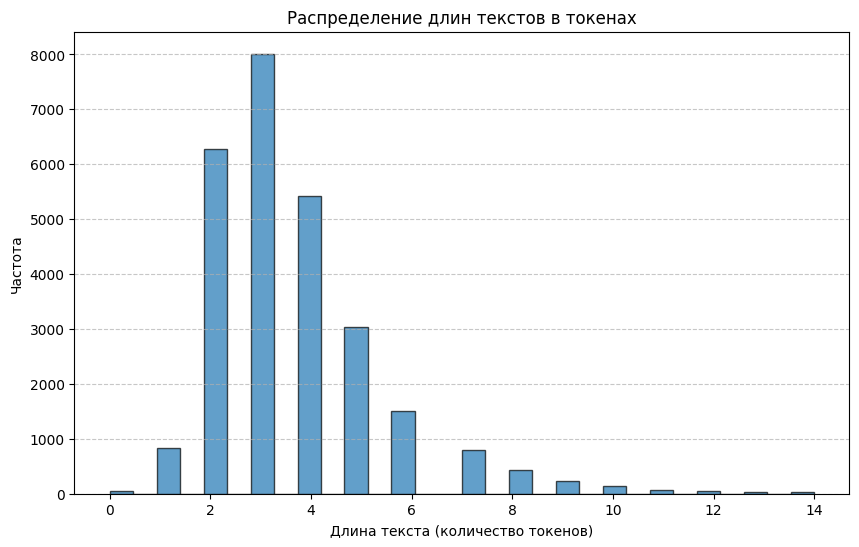

In [199]:
train_dataset.plot_token_length_distribution()

# Модель

In [200]:
num_labels = len(label2idx)

In [201]:
from transformers import AutoConfig
from ml.model import AutoModelForTokenClassificationWithCRF, TokenClassifierCRFOutput

config = AutoConfig.from_pretrained(
    BASE_MODEL_NAME,
    num_labels=num_labels,
    id2label=idx2label,
    label2id=label2idx,
    cache_dir=DATA_CACHE,
)

model = AutoModelForTokenClassificationWithCRF.from_pretrained(
    BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    config=config,
    ignore_mismatched_sizes=True,
)

model.reset_crf_parameters()
# model.crf.init_bio_bias(label2idx, strength=0.7)
model

Some weights of AutoModelForTokenClassificationWithCRF were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['backbone.embeddings.LayerNorm.bias', 'backbone.embeddings.LayerNorm.weight', 'backbone.embeddings.position_embeddings.weight', 'backbone.embeddings.token_type_embeddings.weight', 'backbone.embeddings.word_embeddings.weight', 'backbone.encoder.layer.0.attention.output.LayerNorm.bias', 'backbone.encoder.layer.0.attention.output.LayerNorm.weight', 'backbone.encoder.layer.0.attention.output.dense.bias', 'backbone.encoder.layer.0.attention.output.dense.weight', 'backbone.encoder.layer.0.attention.self.key.bias', 'backbone.encoder.layer.0.attention.self.key.weight', 'backbone.encoder.layer.0.attention.self.query.bias', 'backbone.encoder.layer.0.attention.self.query.weight', 'backbone.encoder.layer.0.attention.self.value.bias', 'backbone.encoder.layer.0.attention.self.value.weight', 'backbone.encoder.layer.0.intermediate.dense.bias', '

AutoModelForTokenClassificationWithCRF(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,)

In [202]:
print("CRF transitions nan?", torch.isnan(model.crf.transitions).any())
print("CRF transitions min/max:", model.crf.transitions.min(), model.crf.transitions.max())

CRF transitions nan? tensor(False)
CRF transitions min/max: tensor(-0.0999, grad_fn=<MinBackward1>) tensor(0.0979, grad_fn=<MaxBackward1>)


# Обучение

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=DATA_PATH_SAVE_MODELS / MODEL_CHECKPOINT_PATH,
    num_train_epochs=6,

    eval_strategy="epoch",
    # eval_strategy="steps",
    # eval_steps=50,  # Оценка модели каждый шаг
    logging_strategy="epoch",
    # logging_strategy="steps",
    # logging_steps=50,  # Как часто логировать
    disable_tqdm=False,  # Отключить tqdm (нужно для работы в Colab/Kaggle)
    report_to="tensorboard",
    logging_dir=DATA_LOG,

    save_strategy="epoch",
    # save_strategy="steps",
    # save_steps=50, # Если save_strategy="steps"
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,


    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
)

In [204]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

steps_per_epoch = len(train_dataset.df) // training_args.per_device_train_batch_size
total_steps = steps_per_epoch * training_args.num_train_epochs


In [205]:
from transformers import get_cosine_schedule_with_warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.2 * total_steps),
    num_training_steps=total_steps 
)

In [206]:
# from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

# scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
#     num_training_steps=total_steps,
#     num_cycles=2,
# )


In [207]:
# from transformers import get_polynomial_decay_schedule_with_warmup

# scheduler = get_polynomial_decay_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
#     num_training_steps=total_steps,
#     lr_end=1e-6,
#     power=2.0,
# )


In [208]:
# from transformers import get_constant_schedule_with_warmup

# scheduler = get_constant_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
# )


In [209]:
def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return torch.argmax(logits, dim=-1)

In [210]:
from collections import Counter


def compute_class_weights(train_dataset, num_labels):
    all_labels = [l for labels in train_dataset.labels.tolist() for l in labels if l != -100]
    counts = Counter(all_labels)
    total = sum(counts.values())
    class_weights = [total / (num_labels * counts.get(i, 1)) for i in range(num_labels)]
    return torch.tensor(class_weights, dtype=torch.float32)


In [211]:
class_weights_tensor = compute_class_weights(train_dataset, num_labels)
class_weights_tensor

tensor([  0.3041,   2.1012,   1.4455, 104.1008,  94.7434,   0.6703,   0.3400,
         21.4014,  22.8514])

In [212]:
from collections import Counter

def show_class_counts_and_ready_weights(train_dataset, idx2label, class_weights_tensor):
    all_labels = []
    for labels in train_dataset.labels.tolist():
        for l in labels:
            if l != -100:
                all_labels.append(l)

    counts = Counter(all_labels)

    print(f"{'Класс':20s} | {'Кол-во':10s} | {'Вес'}")
    print("-"*50)
    for i in range(len(class_weights_tensor)):
        label = idx2label[i]
        count = counts.get(i, 0)
        weight = class_weights_tensor[i].item()
        print(f"{label:20s} | {count:<10d} | {weight:.6f}")


In [213]:
show_class_counts_and_ready_weights(train_dataset, idx2label, class_weights_tensor)


Класс                | Кол-во     | Вес
--------------------------------------------------
O                    | 55453      | 0.304119
B-BRAND              | 8026       | 2.101213
I-BRAND              | 11667      | 1.445473
B-PERCENT            | 162        | 104.100822
I-PERCENT            | 178        | 94.743446
B-TYPE               | 25159      | 0.670310
I-TYPE               | 49608      | 0.339952
B-VOLUME             | 788        | 21.401438
I-VOLUME             | 738        | 22.851400


In [214]:
from collections import Counter

import numpy as np
import torch
from torch.nn import CrossEntropyLoss


def weighted_crf_loss(
    emissions,
    labels,
    attention_mask,
    crf,
    class_weights_tensor,
    alpha=0.7,
):
    labels_for_crf = labels.clone().long()
    labels_for_crf[labels_for_crf == -100] = 0

    crf_loss = -crf(
        emissions,
        labels_for_crf,
        mask=attention_mask.bool(),
        reduction="token_mean"
    )

    logits_flat = emissions.view(-1, emissions.size(-1))
    labels_flat = labels.view(-1)
    ce_loss_fn = CrossEntropyLoss(
        weight=class_weights_tensor.to(emissions.device),
        ignore_index=-100
    )
    ce_loss = ce_loss_fn(logits_flat, labels_flat)
    total_loss = alpha * crf_loss + (1 - alpha) * ce_loss
    return total_loss


def weighted_loss(
    outputs: "TokenClassifierCRFOutput",
    labels,
    model,
    class_weights_tensor,
    alpha=0.7,
    num_items_in_batch=None,
):
    emissions = outputs.logits
    loss = weighted_crf_loss(
        emissions=emissions,
        labels=labels,
        attention_mask=outputs.attention_mask,
        crf=model.crf,
        class_weights_tensor=class_weights_tensor,
        alpha=alpha,
    )
    return loss


In [215]:
from functools import partial

from ml.trainer import CustomBaseTrainer
from ml.metrics import compute_metrics

trainer = CustomBaseTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=partial(compute_metrics, idx2label=idx2label),
    processing_class=train_dataset.tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_loss_func=partial(weighted_loss, model=model, class_weights_tensor=class_weights_tensor, alpha=0.5)
)

In [216]:
trainer.train()

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Micro,F1 Macro,Accuracy
1,1.368800,0.674389,0.510452,0.581074,0.543478,0.285845,0.850200
2,0.460800,0.342605,0.692613,0.773105,0.730649,0.547236,0.924663
3,0.264300,0.279446,0.723982,0.796901,0.758693,0.619137,0.935032
4,0.197500,0.265179,0.758901,0.825678,0.790883,0.654682,0.941654
5,0.162400,0.276003,0.780992,0.836746,0.807908,0.679361,0.946152
6,0.148000,0.274776,0.778292,0.837299,0.806718,0.677549,0.945027


d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be us

TrainOutput(global_step=1266, training_loss=0.4336212679484821, metrics={'train_runtime': 1417.3634, 'train_samples_per_second': 113.844, 'train_steps_per_second': 0.893, 'total_flos': 37219450731264.0, 'train_loss': 0.4336212679484821, 'epoch': 6.0})

In [ ]:
trainer.plot_results()

In [218]:
test_results = trainer.predict(test_dataset)
print(test_results.metrics)

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



{'test_loss': 0.26219072937965393, 'test_precision': 0.7993326978074357, 'test_recall': 0.8461150353178607, 'test_f1_micro': 0.8220588235294117, 'test_f1_macro': 0.6498879956954309, 'test_accuracy': 0.9476574566672387, 'test_runtime': 7.5358, 'test_samples_per_second': 417.472, 'test_steps_per_second': 3.317}


In [221]:
trainer.save_model(DATA_PATH_SAVE_MODELS / MODEL_NAME_SAVE)

# Тестирование модели

In [222]:
from regex import D
from transformers import AutoConfig
from ml.model import AutoModelForTokenClassificationWithCRF, TokenClassifierCRFOutput

num_labels = len(label2idx)

config = AutoConfig.from_pretrained(
    DATA_PATH_SAVE_MODELS / "ner_x5",
    num_labels=num_labels,
    id2label=idx2label,
    label2id=label2idx,
    cache_dir=DATA_CACHE,
)

model = AutoModelForTokenClassificationWithCRF.from_pretrained(
    DATA_PATH_SAVE_MODELS / "ner_x5",
    cache_dir=DATA_CACHE,
    config=config,
    ignore_mismatched_sizes=True,
)

In [223]:
test_dataset.analyze_with_model(
    model=model, 
    idx2label=idx2label, 
    batch_size=64, 
    device="cuda" if torch.cuda.is_available() else "cpu", 
    layer=-1
)

Analyzing with model: 100%|█████████████████████████████████████████| 50/50 [00:06<00:00,  8.18it/s]


In [224]:
# test_dataset.df.sample(10)

In [225]:
print(test_dataset.df["is_correct"].value_counts())

is_correct
True     2630
False     516
Name: count, dtype: int64


In [226]:
df_true = test_dataset.df[test_dataset.df["is_correct"] == True]
df_true.sample(5)

,sample,annotation,df_label,tokens_ids_debug,tokens_text_debug,labels_debug,pred_labels,entities,is_correct
277,огурйы,"[(0, 6, B-TYPE)]",x5,"[2, 46295, 870, 25416, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], огу, ##р, ##йы, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'огурйы'}]",True
397,см4танв,"[(0, 7, B-TYPE)]",x5,"[2, 4159, 1182, 3460, 887, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], см, ##4, ##тан, ##в, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 7, 'entity': 'B-TYPE', 'word': 'см4танв'}]",True
1115,бюстгальтера va,"[(0, 12, B-TYPE), (13, 15, B-BRAND)]",x5,"[2, 53708, 75335, 3414, 725, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], бюст, ##гальт, ##ера, va, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, B-BRAND, O, O, O, O, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, B-BRAND, O, O, O, O, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 12, 'entity': 'B-TYPE', 'word': 'бюстгальтера'}, {'start_index': 13, 'end_index': 15, 'entity': 'B-BRAND', 'word': 'va'}]",True
2974,нори с кимчи,"[(0, 4, B-TYPE), (5, 6, I-TYPE), (7, 12, I-TYPE)]",x5,"[2, 1363, 1690, 329, 3283, 656, 3030, 3, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], но, ##ри, с, ки, ##м, ##чи, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 4, 'entity': 'B-TYPE', 'word': 'нори'}, {'start_index': 5, 'end_index': 6, 'entity': 'I-TYPE', 'word': 'с'}, {'start_index': 7, 'end_index': 12, 'entity': 'I-TYPE', 'word': 'кимчи'}]",True
1700,ацидофильн,"[(0, 10, B-TYPE)]",x5,"[2, 78031, 6762, 36548, 73558, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], ац, ##ид, ##офи, ##льн, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 10, 'entity': 'B-TYPE', 'word': 'ацидофильн'}]",True


In [227]:
df_false = test_dataset.df[test_dataset.df["is_correct"] == False]
df_false.sample(10)

,sample,annotation,df_label,tokens_ids_debug,tokens_text_debug,labels_debug,pred_labels,entities,is_correct
2259,прянк медвй тульскй,"[(0, 6, B-TYPE), (7, 13, I-TYPE), (14, 22, B-BRAND)]",synthetic,"[2, 53709, 865, 29881, 887, 775, 11997, 1903, 3413, 775, 3, 0, 0, 0, 0, 0]","[[CLS], прян, ##к, мед, ##в, ##й, ту, ##ль, ##ск, ##й, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, B-BRAND, I-BRAND, I-BRAND, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 5, 'entity': 'B-TYPE', 'word': 'прянк'}, {'start_index': 6, 'end_index': 11, 'entity': 'I-TYPE', 'word': 'медвй'}, {'start_index': 12, 'end_index': 19, 'entity': 'I-TYPE', 'word': 'тульскй'}]",False
944,зефир шармэль 280 gr,"[(0, 5, B-TYPE), (6, 13, B-BRAND), (14, 20, B-VOLUME)]",synthetic,"[2, 319, 16411, 7100, 29134, 656, 12242, 4770, 9708, 3, 0, 0, 0, 0, 0, 0]","[[CLS], з, ##еф, ##ир, шар, ##м, ##эль, 280, gr, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, B-BRAND, I-BRAND, I-BRAND, B-VOLUME, I-VOLUME, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, B-BRAND, I-BRAND, I-BRAND, B-VOLUME, I-VOLUME, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 5, 'entity': 'B-TYPE', 'word': 'зефир'}, {'start_index': 6, 'end_index': 13, 'entity': 'B-BRAND', 'word': 'шармэль'}, {'start_index': 14, 'end_index': 17, 'entity': 'B-VOLUME', 'word': '280'}, {'start_index': 18, 'end_index': 20, 'entity': 'I-VOLUME', 'word': 'gr'}]",False
2780,Швепс,"[(0, 6, B-BRAND)]",synthetic,"[2, 43527, 44092, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], Шве, ##пс, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, B-BRAND, I-BRAND, O, O, O, O, O, O, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 5, 'entity': 'B-BRAND', 'word': 'Швепс'}]",False
2195,куриное филе для салата,"[(0, 13, B-TYPE), (14, 17, I-TYPE), (18, 24, I-TYPE)]",synthetic,"[2, 31855, 2182, 74900, 871, 76688, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], кури, ##ное, филе, для, салата, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 7, 'entity': 'B-TYPE', 'word': 'куриное'}, {'start_index': 8, 'end_index': 12, 'entity': 'I-TYPE', 'word': 'филе'}, {'start_index': 13, 'end_index': 16, 'entity': 'I-TYPE', 'word': 'для'}, {'start_index': 17, 'end_index': 23, 'entity': 'I-TYPE', 'word': 'салата'}]",False
1744,мармелад haribo 100 g,"[(0, 8, B-TYPE), (9, 15, B-BRAND), (16, 20, B-VOLUME)]",synthetic,"[2, 33839, 3277, 15510, 827, 4670, 559, 793, 74, 3, 0, 0, 0, 0, 0, 0]","[[CLS], мар, ##ме, ##лад, har, ##ib, ##o, 100, g, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, B-BRAND, I-BRAND, I-BRAND, B-VOLUME, O, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, B-BRAND, I-BRAND, I-BRAND, B-VOLUME, I-VOLUME, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 8, 'entity': 'B-TYPE', 'word': 'мармелад'}, {'start_index': 9, 'end_index': 15, 'entity': 'B-BRAND', 'word': 'haribo'}, {'start_index': 16, 'end_index': 19, 'entity': 'B-VOLUME', 'word': '100'}, {'start_index': 20, 'end_index': 21, 'entity': 'I-VOLUME', 'word': 'g'}]",False
1161,libresse прокладки,"[(0, 8, B-BRAND), (9, 18, B-TYPE)]",x5,"[2, 27093, 9789, 538, 70533, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[CLS], lib, ##ress, ##e, прокладки, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, I-BRAND, B-TYPE, O, O, O, O, O, O, O, O, O, O, O]","[O, B-BRAND, I-BRAND, I-BRAND, I-BRAND, O, O, O, O, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 8, 'entity': 'B-BRAND', 'word': 'libresse'}, {'start_index': 9, 'end_index': 18,

# Визуализация по типам

In [228]:
def aggregate_entities(dataset):
    entity_embs = []
    entity_labels = []
    entity_texts = []

    for i, row in dataset.df.iterrows():
        words = dataset._embeddings[i]["words"]
        entropies = dataset._entropies[i]["words"]
        entities = row["entities"]

        for ent in entities:
            if ent["entity"] == "O":
                continue

            start, end = ent["start_index"], ent["end_index"]
            ent_label = ent["entity"].split("-", 1)[-1]
            ent_text = ent.get("word", row["sample"][start:end])

            word_vecs = [w["emb"] for w in words if w["start"] >= start and w["end"] <= end]
            if not word_vecs:
                continue

            ent_vec = torch.stack(word_vecs).mean(dim=0).numpy()
            entity_embs.append(ent_vec)
            entity_labels.append(ent_label)
            entity_texts.append(ent_text)

    entity_df = pd.DataFrame({
        "entity_text": entity_texts,
        "entity_label": entity_labels
    })
    return np.stack(entity_embs), entity_df


In [229]:
from sklearn.preprocessing import LabelEncoder

from ml.visualizer import DynamicEmbeddingVisualizer

entity_embs, entity_df = aggregate_entities(test_dataset)

le = LabelEncoder()
labels = le.fit_transform(entity_df["entity_label"].tolist())

vis = DynamicEmbeddingVisualizer(entity_embs, entity_df, labels=labels)

vis.reduce_dimensionality(method="tsne", n_components=2)

vis.visualize(
    method="tsne",
    title="Entity-level Embeddings",
    hover_columns=["entity_text", "entity_label"],
    idx2label={i: lbl for i, lbl in enumerate(le.classes_)}
)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5379 samples in 0.001s...
[t-SNE] Computed neighbors for 5379 samples in 0.594s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5379
[t-SNE] Computed conditional probabilities for sample 2000 / 5379
[t-SNE] Computed conditional probabilities for sample 3000 / 5379
[t-SNE] Computed conditional probabilities for sample 4000 / 5379
[t-SNE] Computed conditional probabilities for sample 5000 / 5379
[t-SNE] Computed conditional probabilities for sample 5379 / 5379
[t-SNE] Mean sigma: 1.729720
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.221306
[t-SNE] KL divergence after 1000 iterations: 1.370677


# Энтропии

In [ ]:
thresholds = test_dataset.compute_entropy_thresholds(
    idx2label=idx2label,
    method="prc"
)



In [231]:
print("Entropy thresholds per class:")
for k, v in thresholds.items():
    print(f"{k}: {v:.4f}")

Entropy thresholds per class:
B-BRAND: 0.0253
I-BRAND: 0.0324
B-PERCENT: 0.1591
I-PERCENT: 0.2872
B-TYPE: 0.0104
I-TYPE: 0.0174
B-VOLUME: 0.0407
I-VOLUME: 0.0704


In [232]:
avg_threshold = np.mean(list(thresholds.values()))

results_confident = test_dataset.evaluate_accuracy_by_entropy_thresholds(
    thresholds=thresholds,
    avg_threshold=avg_threshold,
    confident=True,
    idx2label=idx2label
)
print("\n=== Уверенные предсказания ===")
print(f"Точность: {results_confident['accuracy']:.2%}")


Samples selected: 2839
Accuracy (confident): 94.12%
Coverage: 90.24%

=== Уверенные предсказания ===
Точность: 94.12%


In [248]:
results_confident["predictions_df"].sample(10)

,text,entity_text,true_entities,pred_entity,entropy,threshold,correct
1929,витчин,витчин,"[(0, 6, B-TYPE)]",B-TYPE,0.039429,0.080367,1
1199,тесто дл пельменей,дл,"[(9, 18, I-TYPE), (0, 5, B-TYPE), (6, 8, I-TYPE)]",I-TYPE,0.071702,0.080367,1
269,роликовый антиперспирант долгийй,долгийй,"[(11, 26, I-TYPE), (27, 34, I-TYPE), (0, 10, B-TYPE)]",I-TYPE,0.070966,0.080367,0
1334,грушевы,грушевы,"[(0, 7, B-TYPE)]",B-TYPE,0.053099,0.080367,1
483,слабосолёная,слабосолёная,"[(0, 12, B-TYPE)]",B-TYPE,0.033280,0.080367,1
1188,молоко для закваски,молоко,"[(11, 19, I-TYPE), (7, 10, I-TYPE), (0, 6, B-TYPE)]",B-TYPE,0.015985,0.080367,1
1,капченая,капченая,"[(0, 8, B-TYPE)]",B-TYPE,0.025153,0.080367,1
2333,лонганища,лонганища,"[(0, 9, B-TYPE)]",B-TYPE,0.050219,0.080367,1
2201,масло evo,масло,"[(6, 9, B-BRAND), (0, 5, B-TYPE)]",B-TYPE,0.031497,0.080367,1
1899,щтка д обув,щтка,"[(8, 13, I-TYPE), (0, 5, B-TYPE), (6, 7, I-TYPE)]",B-TYPE,0.033972,0.080367,0


In [234]:
results_uncertain = test_dataset.evaluate_accuracy_by_entropy_thresholds(
    thresholds=thresholds,
    avg_threshold=avg_threshold,
    confident=False,
    idx2label=idx2label
)

print("\n=== Неуверенные предсказания ===")
print(f"Точность: {results_uncertain['accuracy']:.2%}")

Samples selected: 2540
Accuracy (uncertain): 71.30%
Coverage: 80.74%

=== Неуверенные предсказания ===
Точность: 71.30%


In [235]:
results_uncertain["predictions_df"].sample(10)

,text,entity_text,true_entities,pred_entity,entropy,threshold,correct
2009,лук к жарк,к,"[(4, 5, I-TYPE), (6, 10, I-TYPE), (0, 3, B-TYPE)]",I-TYPE,0.181972,0.080367,1
2459,lav,lav,"[(0, 3, B-BRAND)]",B-BRAND,0.225920,0.080367,1
1569,средств дл малышей гиген,дл,"[(11, 18, I-TYPE), (0, 7, B-TYPE), (8, 10, I-TYPE), (19, 24, I-TYPE)]",I-TYPE,0.083989,0.080367,1
2406,торти cara,торти,"[(6, 10, B-BRAND), (0, 5, B-TYPE)]",B-TYPE,0.090895,0.080367,1
1127,пасха растишка,растишка,"[(6, 14, B-BRAND), (0, 5, B-TYPE)]",B-BRAND,0.563129,0.080367,1
1898,степь н,н,"[(6, 7, B-TYPE), (0, 5, B-BRAND)]",I-BRAND,0.771589,0.080367,0
671,спагнети,спагнети,"[(0, 8, B-TYPE)]",B-TYPE,0.103290,0.080367,1
1713,лосьон длы малышей гигиен,гигиен,"[(20, 26, I-TYPE), (11, 19, I-TYPE), (7, 10, I-TYPE), (0, 6, B-TYPE)]",I-TYPE,0.092372,0.080367,0
1438,мармелад haribo 100 g,100,"[(16, 20, B-VOLUME), (9, 15, B-BRAND), (0, 8, B-TYPE)]",B-VOLUME,0.233006,0.080367,0
2056,brayer кофеварок,кофеварок,"[(7, 16, B-TYPE), (0, 6, B-BRAND)]",B-TYPE,0.217527,0.080367,1


# Ручное тестирование

In [236]:
import json
from pathlib import Path

from ml.pipline import NERPipelineCRF

model_dir = DATA_PATH_SAVE_MODELS / "ner_x5"
label2idx_path = DATA_PATH_SAVE_MODELS / "label2idx.json"
idx2label_path = DATA_PATH_SAVE_MODELS / "idx2label.json"

with open(label2idx_path, "r", encoding="utf-8") as f:
    label2idx = json.load(f)

with open(idx2label_path, "r", encoding="utf-8") as f:
    idx2label = {int(k): v for k, v in json.load(f).items()}

pipeline = NERPipelineCRF(
    model_path=model_dir,
    label2idx=label2idx,
    idx2label=idx2label,
    max_length=16
)


In [237]:
text = [
    "йогурт данисимо фантазия",
    "молоко простоквашино 3.2% 930г",
    "хлеб бородинский нарезка 300г",
    "мороженнае как бы его взтять",
    "молоко⁷ цельное",
    "паштет для кошки",
    "погремушки fisher-pri",   
    "сырокопченая-колбаск",
    "мясное пюре для пупсов, 250г,",
]
entities = pipeline.predict(text, return_word=True)

for i, entity in enumerate(entities):
    print(f"Текст: {text[i]}")
    print(entity)

Текст: йогурт данисимо фантазия
[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'йогурт'}, {'start_index': 7, 'end_index': 15, 'entity': 'B-BRAND', 'word': 'данисимо'}, {'start_index': 16, 'end_index': 24, 'entity': 'I-BRAND', 'word': 'фантазия'}]
Текст: молоко простоквашино 3.2% 930г
[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'молоко'}, {'start_index': 7, 'end_index': 20, 'entity': 'B-BRAND', 'word': 'простоквашино'}, {'start_index': 21, 'end_index': 25, 'entity': 'B-PERCENT', 'word': '3.2%'}, {'start_index': 26, 'end_index': 30, 'entity': 'B-VOLUME', 'word': '930г'}]
Текст: хлеб бородинский нарезка 300г
[{'start_index': 0, 'end_index': 4, 'entity': 'B-TYPE', 'word': 'хлеб'}, {'start_index': 5, 'end_index': 16, 'entity': 'I-TYPE', 'word': 'бородинский'}, {'start_index': 17, 'end_index': 24, 'entity': 'I-TYPE', 'word': 'нарезка'}, {'start_index': 25, 'end_index': 29, 'entity': 'B-VOLUME', 'word': '300г'}]
Текст: мороженнае как бы его взтять
[{'start

In [238]:
import pandas as pd
from tqdm import tqdm

def run_inference_on_dataframe(
    pipeline, 
    df: pd.DataFrame,
    text_col: str = "sample", 
    batch_size: int = 64
) -> pd.DataFrame:
    
    texts = df[text_col].tolist()
    all_entities = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Running inference", ncols=100):
        batch_texts = texts[i:i+batch_size]
        batch_entities = pipeline.predict(batch_texts, batch_size=batch_size)
        all_entities.extend(batch_entities)

    formatted_entities = [
        [(ent["start_index"], ent["end_index"], ent["entity"]) for ent in ents]
        for ents in all_entities
    ]

    df_result = pd.DataFrame({
        "id": range(1, len(texts) + 1),
        "search_query": texts,
        "annotation": formatted_entities
    })

    return df_result


In [239]:
df_result = run_inference_on_dataframe(pipeline, df_submission, text_col="sample", batch_size=64)


Running inference: 100%|████████████████████████████████████████████| 79/79 [00:05<00:00, 13.23it/s]


In [240]:
df_result.sample(5)

,id,search_query,annotation
1778,1779,торт прага,"[(0, 4, B-TYPE), (5, 10, I-TYPE)]"
1448,1449,перец острый молотый,"[(0, 5, B-TYPE), (6, 12, I-TYPE), (13, 20, I-TYPE)]"
1445,1446,сахарная,"[(0, 8, B-TYPE)]"
2560,2561,яблоко персик,"[(0, 6, B-TYPE), (7, 13, I-TYPE)]"
1925,1926,печенье сдобное,"[(0, 7, B-TYPE), (8, 15, I-TYPE)]"


In [241]:
df_result.to_csv(DATA_PATH_DOWNLOAD /  "submission.csv", index=False, sep=";")
